<!-- Notebook title -->
# Classification

# 1. Notebook Description

### 1.1 Task Description
<!-- 
- A brief description of the problem you're solving with machine learning.
- Define the objective (e.g., classification, regression, clustering, etc.).
-->

TODO

---

# 2. Setup

In [1]:
from ikt450.src.common_imports import *
from ikt450.src.config import get_paths
from ikt450.src.common_func import load_dataset, save_dataframe, ensure_dir_exists

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter
from itertools import chain
from torch.nn.utils.rnn import pad_sequence
import torch

import kagglehub
import shutil
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

In [2]:
paths = get_paths()

In [3]:
RANDOM_SEED = 7

In [4]:
SPLITRATIO = 0.8

---

## 4.1 Data loading
<!--
- Load datasets from files or other sources.
-->

In [5]:
# (Tror ikke denne virker på eduVPN)
path = kagglehub.dataset_download("stackoverflow/pythonquestions", force_download=True)
print(path)

target_path = f"{paths['PATH_COMMON_DATASETS']}/pythonQuestions"
versioned_target_path = os.path.join(target_path, os.path.basename(path))
os.makedirs(target_path, exist_ok=True)
if os.path.exists(versioned_target_path):
    shutil.rmtree(versioned_target_path)  # Clear previous version if exists
shutil.copytree(path, versioned_target_path)


100%|██████████| 558M/558M [00:17<00:00, 32.7MB/s] 

Extracting files...


/home/jon/.cache/kagglehub/datasets/stackoverflow/pythonquestions/versions/2


'/home/jon/projects/ikt450/common/datasets/pythonQuestions/2'

In [6]:
questions_df = pd.read_csv(f"{paths['PATH_COMMON_DATASETS']}/pythonQuestions/2/Questions.csv", delimiter=",", encoding="latin-1")
tags_df = pd.read_csv(f"{paths['PATH_COMMON_DATASETS']}/pythonQuestions/2/Tags.csv", delimiter=",", encoding="latin-1")
answers_df = pd.read_csv(f"{paths['PATH_COMMON_DATASETS']}/pythonQuestions/2/Answers.csv", delimiter=",", encoding="latin-1")

### 4.2.1 Info

In [7]:
print(tags_df.info())
print(questions_df.info())
print(answers_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885078 entries, 0 to 1885077
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 28.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            607282 non-null  int64  
 1   OwnerUserId   601070 non-null  float64
 2   CreationDate  607282 non-null  object 
 3   Score         607282 non-null  int64  
 4   Title         607282 non-null  object 
 5   Body          607282 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 27.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            98712

### 4.2.2 Describe

In [8]:
num_tags = len(list(tags_df["Tag"].unique()))
unique_tags = list(tags_df["Tag"].unique())

In [9]:
num_tags

16896

In [10]:
questions_df

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
...,...,...,...,...,...,...
607277,40143190,333403.0,2016-10-19T23:36:01Z,1,How to execute multiline python code from a ba...,<p>I need to extend a shell script (bash). As ...
607278,40143228,6662462.0,2016-10-19T23:40:00Z,0,How to get google reCaptcha image source using...,<p>I understood that reCaptcha loads a new fra...
607279,40143267,4064680.0,2016-10-19T23:44:07Z,0,Updating an ManyToMany field with Django rest,<p>I'm trying to set up this API so I can use ...
607280,40143338,7044980.0,2016-10-19T23:52:27Z,2,Most possible pairs,"<p>Given a list of values, and information on ..."


In [11]:
tags_grouped = tags_df.groupby('Id')['Tag'].apply(list).reset_index(name='Tags')
questions_and_tags_df = questions_df.merge(tags_grouped,on="Id")

In [12]:
answers_and_questions_df = answers_df.merge(questions_and_tags_df, left_on="ParentId", right_on="Id", suffixes=('_answer', '_question'))
answers_and_questions_df
# merge the answers and questions with tags dataframes
answers_and_questions_df = answers_and_questions_df.merge(tags_grouped, left_on="ParentId", right_on="Id", suffixes=('_answer', '_question'))
answers_and_questions_df

,Id_answer,OwnerUserId_answer,CreationDate_answer,ParentId,Score_answer,Body_answer,Id_question,OwnerUserId_question,CreationDate_question,Score_question,Title,Body_question,Tags_answer,Id,Tags_question
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,"[python, osx, fonts, photoshop]",469,"[python, osx, fonts, photoshop]"
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,"[python, osx, fonts, photoshop]",469,"[python, osx, fonts, photoshop]"
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,"[python, windows, image, pdf]",502,"[python, windows, image, pdf]"
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,"[python, continuous-integration, extreme-progr...",535,"[python, continuous-integration, extreme-progr..."
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,"[python, continuous-integration, extreme-progr...",535,"[python, continuous-integration, extreme-progr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987117,40143290,3831.0,2016-10-19T23:46:58Z,40142906,0,<p>I am fairly certain your problem is your us...,40142906,7044946.0,2016-10-19T23:05:34Z,2,can't assign to function call Error-Python,<p>So I'm working on a project to create a pos...,"[python, syntax-error, barcode]",40142906,"[python, syntax-error, barcode]"
987118,40143315,3125566.0,2016-10-19T23:49:43Z,40143166,2,"<p>First thing, you should use <code>if/elif</...",40143166,7044992.0,2016-10-19T23:33:31Z,1,finding cubed root using delta and epsilon in ...,<p>I am trying to write a program that finds c...,"[python, python-3.x]",40143166,"[python, python-3.x]"
987119,40143317,2350575.0,2016-10-19T23:50:04Z,40142194,0,<p>If you are using firefox ver >47.0.1 you ne...,40142194,7044759.0,2016-10-19T21:58:32Z,1,errors with webdriver.Firefox() with selenium,"<p>I am using python 3.5, firefox 45 (also tri...","[python, selenium, firefox]",40142194,"[python, selenium, firefox]"
987120,40143349,6934347.0,2016-10-19T23:54:02Z,40077010,0,<p>I solved my own problem defining the follow...,40077010,6934347.0,2016-10-17T00:33:51Z,2,Can't pass random variable to tf.image.central...,<p>In Tensorflow I am training from a set of P...,"[python, tensorflow]",40077010,"[python, tensorflow]"


In [13]:
# keep only the columns we need
# answers body and tag
answers_and_questions_df = answers_and_questions_df[["Body_answer", "Tags_question"]]
answers_and_questions_df

,Body_answer,Tags_question
0,<p>open up a terminal (Applications-&gt;Utilit...,"[python, osx, fonts, photoshop]"
1,<p>I haven't been able to find anything that d...,"[python, osx, fonts, photoshop]"
2,<p>You can use ImageMagick's convert utility f...,"[python, windows, image, pdf]"
3,<p>One possibility is Hudson. It's written in...,"[python, continuous-integration, extreme-progr..."
4,"<p>We run <a href=""http://buildbot.net/trac"">B...","[python, continuous-integration, extreme-progr..."
...,...,...
987117,<p>I am fairly certain your problem is your us...,"[python, syntax-error, barcode]"
987118,"<p>First thing, you should use <code>if/elif</...","[python, python-3.x]"
987119,<p>If you are using firefox ver >47.0.1 you ne...,"[python, selenium, firefox]"
987120,<p>I solved my own problem defining the follow...,"[python, tensorflow]"


In [14]:
# find the most common tags
tag_count = {}
for tags in questions_and_tags_df["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

tag_count        

{'python': 607282,
 'osx': 5056,
 'fonts': 326,
 'photoshop': 30,
 'windows': 6267,
 'image': 2894,
 'pdf': 1125,
 'continuous-integration': 96,
 'extreme-programming': 1,
 'sql': 3478,
 'database': 3043,
 'oracle': 480,
 'cx-oracle': 379,
 'arrays': 9170,
 'iteration': 1185,
 'django': 62818,
 'views': 187,
 'oop': 2251,
 'mysql': 7529,
 'postgresql': 3591,
 'bpgsql': 1,
 'methods': 1026,
 'monkeypatching': 203,
 'syntax': 1019,
 'binary': 872,
 'integer': 684,
 'literals': 67,
 'xml': 5332,
 'protocol-buffers': 220,
 'list': 18951,
 'tuples': 2419,
 'php': 2741,
 'ftp': 567,
 'webserver': 355,
 'user-interface': 3221,
 'deployment': 482,
 'tkinter': 10766,
 'release-management': 5,
 'linux': 7121,
 'serial-port': 723,
 'ruby-on-rails': 224,
 'ruby': 1044,
 'apache': 2313,
 'apache2': 244,
 'c': 2948,
 'matlab': 1531,
 'markup': 46,
 'floating-point': 920,
 'unicode': 4135,
 'urllib': 1536,
 'data-structures': 951,
 'pylons': 612,
 'dom': 200,
 'xpath': 1822,
 'nodes': 154,
 'mp3': 20

In [15]:
# sort the tags by count
sorted_tags = sorted(tag_count.items(), key=lambda x: x[1], reverse=True)
sorted_tags

[('python', 607282),
 ('django', 62818),
 ('python-2.7', 34616),
 ('pandas', 26854),
 ('python-3.x', 26814),
 ('numpy', 25848),
 ('list', 18951),
 ('matplotlib', 16521),
 ('regex', 14047),
 ('dictionary', 13413),
 ('tkinter', 10766),
 ('string', 10616),
 ('flask', 10488),
 ('google-app-engine', 10286),
 ('csv', 9323),
 ('arrays', 9170),
 ('json', 8023),
 ('mysql', 7529),
 ('linux', 7121),
 ('html', 7118),
 ('scipy', 6908),
 ('multithreading', 6804),
 ('sqlalchemy', 6661),
 ('windows', 6267),
 ('beautifulsoup', 6054),
 ('django-models', 5797),
 ('javascript', 5788),
 ('selenium', 5654),
 ('xml', 5332),
 ('pyqt', 5217),
 ('class', 5083),
 ('osx', 5056),
 ('pygame', 5050),
 ('opencv', 4995),
 ('dataframe', 4958),
 ('function', 4867),
 ('c++', 4850),
 ('file', 4665),
 ('scrapy', 4638),
 ('sockets', 4585),
 ('subprocess', 4418),
 ('loops', 4355),
 ('scikit-learn', 4289),
 ('pip', 4178),
 ('algorithm', 4168),
 ('unicode', 4135),
 ('parsing', 4062),
 ('datetime', 4040),
 ('web-scraping', 3940

In [16]:
# get the top 10 tags
class_count = 10

In [17]:
# get the top 100 with out the top 10
top_100_tags = [tag for tag, count in sorted_tags[10:(10+class_count)]]
top_100_tags

['tkinter',
 'string',
 'flask',
 'google-app-engine',
 'csv',
 'arrays',
 'json',
 'mysql',
 'linux',
 'html']

In [18]:
# filter the questions to only include the top 100 tags
questions_and_tags_df["Tags"] = questions_and_tags_df["Tags"].apply(lambda tags: [tag for tag in tags if tag in top_100_tags])

In [19]:
# filter the answers to only include the top 100 tags
answers_and_questions_df["Tags_question"] = answers_and_questions_df["Tags_question"].apply(lambda tags: [tag for tag in tags if tag in top_100_tags])
answers_and_questions_df

/tmp/ipykernel_342553/2716587526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_and_questions_df["Tags_question"] = answers_and_questions_df["Tags_question"].apply(lambda tags: [tag for tag in tags if tag in top_100_tags])


,Body_answer,Tags_question
0,<p>open up a terminal (Applications-&gt;Utilit...,[]
1,<p>I haven't been able to find anything that d...,[]
2,<p>You can use ImageMagick's convert utility f...,[]
3,<p>One possibility is Hudson. It's written in...,[]
4,"<p>We run <a href=""http://buildbot.net/trac"">B...",[]
...,...,...
987117,<p>I am fairly certain your problem is your us...,[]
987118,"<p>First thing, you should use <code>if/elif</...",[]
987119,<p>If you are using firefox ver >47.0.1 you ne...,[]
987120,<p>I solved my own problem defining the follow...,[]


In [20]:
# remove questions with no tags 
questions_and_tags_df = questions_and_tags_df[questions_and_tags_df["Tags"].apply(len) > 0]
questions_and_tags_df

,Id,OwnerUserId,CreationDate,Score,Title,Body,Tags
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,[arrays]
6,766,1384652.0,2008-08-03T17:44:07Z,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...,[mysql]
15,2933,1384652.0,2008-08-05T22:26:00Z,171,How can I create a directly-executable cross-p...,<p>Python works on multiple platforms and can ...,[tkinter]
17,3976,556.0,2008-08-06T21:00:01Z,12,Programmatically talking to a Serial Port in O...,<p>I have a Prolite LED sign that I like to se...,[linux]
26,8154,736.0,2008-08-11T19:59:32Z,10,Pylons error - 'MySQL server has gone away',<p>[I hope this isn't too obscure&hellip; I'll...,[mysql]
...,...,...,...,...,...,...,...
607252,40142552,3327587.0,2016-10-19T22:29:01Z,0,Python code for changing relative links in a w...,<p>I would like make a website that shows cont...,[html]
607255,40142668,6941910.0,2016-10-19T22:40:52Z,0,how can I exit a tkinter window after changing...,<p>So I'm trying to make a little battle scene...,[tkinter]
607261,40142766,4114372.0,2016-10-19T22:50:49Z,0,How to remove elements from a nested json with...,<p>I have the following json:</p>\n\n<p>{</p>\...,[json]
607263,40142811,2679662.0,2016-10-19T22:55:05Z,2,Different result for String and Integers using...,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json]


In [21]:
# remove questions with two or more tags
questions_and_tags_df = questions_and_tags_df[questions_and_tags_df["Tags"].apply(len) == 1]
questions_and_tags_df

,Id,OwnerUserId,CreationDate,Score,Title,Body,Tags
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,[arrays]
6,766,1384652.0,2008-08-03T17:44:07Z,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...,[mysql]
15,2933,1384652.0,2008-08-05T22:26:00Z,171,How can I create a directly-executable cross-p...,<p>Python works on multiple platforms and can ...,[tkinter]
17,3976,556.0,2008-08-06T21:00:01Z,12,Programmatically talking to a Serial Port in O...,<p>I have a Prolite LED sign that I like to se...,[linux]
26,8154,736.0,2008-08-11T19:59:32Z,10,Pylons error - 'MySQL server has gone away',<p>[I hope this isn't too obscure&hellip; I'll...,[mysql]
...,...,...,...,...,...,...,...
607252,40142552,3327587.0,2016-10-19T22:29:01Z,0,Python code for changing relative links in a w...,<p>I would like make a website that shows cont...,[html]
607255,40142668,6941910.0,2016-10-19T22:40:52Z,0,how can I exit a tkinter window after changing...,<p>So I'm trying to make a little battle scene...,[tkinter]
607261,40142766,4114372.0,2016-10-19T22:50:49Z,0,How to remove elements from a nested json with...,<p>I have the following json:</p>\n\n<p>{</p>\...,[json]
607263,40142811,2679662.0,2016-10-19T22:55:05Z,2,Different result for String and Integers using...,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json]


In [22]:
# remove answers with no tags
answers_and_questions_df = answers_and_questions_df[answers_and_questions_df["Tags_question"].apply(len) > 0]
answers_and_questions_df

,Body_answer,Tags_question
7,"<p>No, you were not dreaming. Python has a pr...",[arrays]
8,<p>I think:</p>\r\n\r\n<pre><code>#!/bin/pytho...,[arrays]
9,<p>Are you looking to get a list of objects th...,[arrays]
10,<p>What I was thinking of can be achieved usin...,[arrays]
12,"<p>I don't have any experience with <a href=""h...",[mysql]
...,...,...
987089,<p>For <strong><em>storing the sorted list as ...,[arrays]
987092,"<p><strong>For anyone else facing this issue, ...","[mysql, flask]"
987098,<p>That is actually how your data is:</p>\n\n<...,[json]
987100,<p>Editting based on the <em>edit</em> in the ...,[json]


In [23]:
# remove answers with two or more tags
answers_and_questions_df = answers_and_questions_df[answers_and_questions_df["Tags_question"].apply(len) == 1]
answers_and_questions_df

,Body_answer,Tags_question
7,"<p>No, you were not dreaming. Python has a pr...",[arrays]
8,<p>I think:</p>\r\n\r\n<pre><code>#!/bin/pytho...,[arrays]
9,<p>Are you looking to get a list of objects th...,[arrays]
10,<p>What I was thinking of can be achieved usin...,[arrays]
12,"<p>I don't have any experience with <a href=""h...",[mysql]
...,...,...
987087,<p>try this:</p>\n\n<pre><code>my_list.sort(ke...,[arrays]
987089,<p>For <strong><em>storing the sorted list as ...,[arrays]
987098,<p>That is actually how your data is:</p>\n\n<...,[json]
987100,<p>Editting based on the <em>edit</em> in the ...,[json]


In [24]:
# remove id, owneruserid,creationdate,scoure 
questions_and_tags_df = questions_and_tags_df.drop(columns=["Id","OwnerUserId","CreationDate","Score","Title"])
questions_and_tags_df

,Body,Tags
4,<p>I don't remember whether I was dreaming or ...,[arrays]
6,<p>I can get Python to work with Postgresql bu...,[mysql]
15,<p>Python works on multiple platforms and can ...,[tkinter]
17,<p>I have a Prolite LED sign that I like to se...,[linux]
26,<p>[I hope this isn't too obscure&hellip; I'll...,[mysql]
...,...,...
607252,<p>I would like make a website that shows cont...,[html]
607255,<p>So I'm trying to make a little battle scene...,[tkinter]
607261,<p>I have the following json:</p>\n\n<p>{</p>\...,[json]
607263,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json]


In [25]:
questions_and_tags_df = questions_and_tags_df.rename(columns={"Body":"Question"})
questions_and_tags_df = questions_and_tags_df.rename(columns={"Tags":"Class"})
questions_and_tags_df

,Question,Class
4,<p>I don't remember whether I was dreaming or ...,[arrays]
6,<p>I can get Python to work with Postgresql bu...,[mysql]
15,<p>Python works on multiple platforms and can ...,[tkinter]
17,<p>I have a Prolite LED sign that I like to se...,[linux]
26,<p>[I hope this isn't too obscure&hellip; I'll...,[mysql]
...,...,...
607252,<p>I would like make a website that shows cont...,[html]
607255,<p>So I'm trying to make a little battle scene...,[tkinter]
607261,<p>I have the following json:</p>\n\n<p>{</p>\...,[json]
607263,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json]


In [26]:
# select first 10000 rows
questions_and_tags_df = questions_and_tags_df[:100000]
questions_and_tags_df

,Question,Class
4,<p>I don't remember whether I was dreaming or ...,[arrays]
6,<p>I can get Python to work with Postgresql bu...,[mysql]
15,<p>Python works on multiple platforms and can ...,[tkinter]
17,<p>I have a Prolite LED sign that I like to se...,[linux]
26,<p>[I hope this isn't too obscure&hellip; I'll...,[mysql]
...,...,...
607252,<p>I would like make a website that shows cont...,[html]
607255,<p>So I'm trying to make a little battle scene...,[tkinter]
607261,<p>I have the following json:</p>\n\n<p>{</p>\...,[json]
607263,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json]


In [27]:
# select first 10000 rows
answers_and_questions_df = answers_and_questions_df[:25000]
answers_and_questions_df

,Body_answer,Tags_question
7,"<p>No, you were not dreaming. Python has a pr...",[arrays]
8,<p>I think:</p>\r\n\r\n<pre><code>#!/bin/pytho...,[arrays]
9,<p>Are you looking to get a list of objects th...,[arrays]
10,<p>What I was thinking of can be achieved usin...,[arrays]
12,"<p>I don't have any experience with <a href=""h...",[mysql]
...,...,...
207295,"<p>You can use Python's <a href=""http://docs.p...",[csv]
207298,<p>This is the sort of thing Python is great f...,[csv]
207300,"<p><a href=""http://stackoverflow.com/a/9489862...",[csv]
207303,"<p>It is very simple with <a href=""http://pand...",[csv]


In [28]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Remove leading <p> tags
    text = re.sub(r'^<p>', '', text)
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize, remove stopwords, then lemmatize words
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

# Apply preprocessing to the 'text' column
questions_and_tags_df['processed_text'] = questions_and_tags_df['Question'].apply(preprocess_text)

/tmp/ipykernel_342553/2004598955.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_and_tags_df['processed_text'] = questions_and_tags_df['Question'].apply(preprocess_text)


In [29]:
questions_and_tags_df

,Question,Class,processed_text
4,<p>I don't remember whether I was dreaming or ...,[arrays],dont remember whether dreaming seem recall fun...
6,<p>I can get Python to work with Postgresql bu...,[mysql],get python work postgresql cannot get work mys...
15,<p>Python works on multiple platforms and can ...,[tkinter],python work multiple platform used desktop web...
17,<p>I have a Prolite LED sign that I like to se...,[linux],prolite led sign like set show scrolling searc...
26,<p>[I hope this isn't too obscure&hellip; I'll...,[mysql],hope isnt obscurehellip ill ask newsgroup nobo...
...,...,...,...
607252,<p>I would like make a website that shows cont...,[html],would like make website show content website e...
607255,<p>So I'm trying to make a little battle scene...,[tkinter],im trying make little battle scene using tkint...
607261,<p>I have the following json:</p>\n\n<p>{</p>\...,[json],following jsonp pp precodestatus 4 item token_...
607263,<p><strong>EDIT:</strong>\nAs @Alfe suggested ...,[json],strongeditstrong alfe suggested comment exact ...


In [30]:
# Set threshold for minimum word frequency
min_freq = 5  # or a suitable value based on your data
max_length = 100  # Maximum sequence length

# Step 1: Tokenize and Build Vocabulary with a Frequency Filter
tokenized_texts = questions_and_tags_df['processed_text'].apply(lambda x: x.split())
word_counts = Counter(chain(*tokenized_texts))

# Build vocabulary with words meeting the min frequency requirement
vocab = {word: idx + 2 for idx, (word, count) in enumerate(word_counts.items()) if count >= min_freq}  # Start at 2
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1  # Unknown token for rare words

# Step 2: Encode Texts with Unknown Token Handling
questions_and_tags_df['encoded_text'] = tokenized_texts.apply(
    lambda x: [vocab.get(word, vocab['<UNK>']) for word in x]  # Use <UNK> for words not in vocab
)

# Step 3: Pad or Truncate Sequences
questions_and_tags_df['padded_text'] = questions_and_tags_df['encoded_text'].apply(
    lambda x: x[:max_length] + [vocab['<PAD>']] * (max_length - len(x)) if len(x) < max_length else x[:max_length]
)

# Convert to tensor
x = torch.tensor(questions_and_tags_df['padded_text'].tolist())


/tmp/ipykernel_342553/2255206345.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_and_tags_df['encoded_text'] = tokenized_texts.apply(
/tmp/ipykernel_342553/2255206345.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_and_tags_df['padded_text'] = questions_and_tags_df['encoded_text'].apply(


In [31]:
# find max value in x
max_value = x.max().item()
max_value

invalid_indices = x >= len(vocab)
if invalid_indices.any():
    print(f"Found {invalid_indices.sum().item()} invalid indices, setting them to '<UNK>' token.")
    x[invalid_indices] = vocab['<UNK>']

max_value = x.max().item()
max_value


Found 351836 invalid indices, setting them to '<UNK>' token.


82106

In [32]:
len(vocab)

82115

In [33]:
y = questions_and_tags_df['Class']

In [34]:
y = y.apply(lambda x: x[0])
y = y.apply(lambda x: top_100_tags.index(x))
y = y.to_numpy()

np.mean(y)

4.013638921818683

In [35]:
# apply the same preprocessing to tags in answers dataframe 
answers_and_questions_df["processed_text"] = answers_and_questions_df["Body_answer"]

# to tags
answers_and_questions_df["Class"] = answers_and_questions_df["Tags_question"].apply(lambda tags: tags[0])
answers_and_questions_df["Class"] = answers_and_questions_df["Class"].apply(lambda x: top_100_tags.index(x))

/tmp/ipykernel_342553/548485312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_and_questions_df["processed_text"] = answers_and_questions_df["Body_answer"]
/tmp/ipykernel_342553/548485312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_and_questions_df["Class"] = answers_and_questions_df["Tags_question"].apply(lambda tags: tags[0])
/tmp/ipykernel_342553/548485312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [36]:
answers_and_questions_df

,Body_answer,Tags_question,processed_text,Class
7,"<p>No, you were not dreaming. Python has a pr...",[arrays],"<p>No, you were not dreaming. Python has a pr...",5
8,<p>I think:</p>\r\n\r\n<pre><code>#!/bin/pytho...,[arrays],<p>I think:</p>\r\n\r\n<pre><code>#!/bin/pytho...,5
9,<p>Are you looking to get a list of objects th...,[arrays],<p>Are you looking to get a list of objects th...,5
10,<p>What I was thinking of can be achieved usin...,[arrays],<p>What I was thinking of can be achieved usin...,5
12,"<p>I don't have any experience with <a href=""h...",[mysql],"<p>I don't have any experience with <a href=""h...",7
...,...,...,...,...
207295,"<p>You can use Python's <a href=""http://docs.p...",[csv],"<p>You can use Python's <a href=""http://docs.p...",4
207298,<p>This is the sort of thing Python is great f...,[csv],<p>This is the sort of thing Python is great f...,4
207300,"<p><a href=""http://stackoverflow.com/a/9489862...",[csv],"<p><a href=""http://stackoverflow.com/a/9489862...",4
207303,"<p>It is very simple with <a href=""http://pand...",[csv],"<p>It is very simple with <a href=""http://pand...",4


In [37]:
x = torch.tensor(x)
y = torch.tensor(y)

/tmp/ipykernel_342553/761844117.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


In [38]:
x.shape, y.shape

(torch.Size([83511, 100]), torch.Size([83511]))

In [39]:
# Split the data into training and testing sets


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([66808, 100]),
 torch.Size([16703, 100]),
 torch.Size([66808]),
 torch.Size([16703]))

In [40]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)


### 4.2.3 Head

## 4.3 Data Visualization

## 4.4 Data Cleaning
<!--
- Handle missing values, outliers, and inconsistencies.
- Remove or impute missing data.
-->

### 4.4.1 NULL, NaN, Missing values

## 4.5 Feature Engineering
<!--
- Create new features from existing data.
- Normalize or standardize features.
- Encode categorical variables.
-->

## 4.6 Data Splitting
<!--
- Split data into training, validation, and test sets.
-->

In [41]:
# Sklearn train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-SPLITRATIO), random_state=RANDOM_SEED)

---

# 5. Model Development

## 5.1 Model Selection
<!--
- Choose the model(s) to be trained (e.g., linear regression, decision trees, neural networks).
-->

In [42]:
class ClassificationModel(nn.Module):
    def __init__(self, num_tags, vocab_size, embedding_dim=100):
        super(ClassificationModel, self).__init__()
        
        # Embedding layer with randomly initialized embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # Set padding_idx to 0 to ignore padding token
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=512, num_layers=1, batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2, 512)
        self.fc2 = nn.Linear(512, num_tags)
    
    def forward(self, input):
        # Pass input through embedding layer
        x = self.embedding(input)  # Shape: [batch_size, sequence_length, embedding_dim]
        
        # LSTM layer
        output, _ = self.lstm(x)  # output shape: [batch_size, sequence_length, hidden_size * 2]
        
        # Extract the output at the last time step
        x = self.fc1(output[:, -1, :])  # Shape: [batch_size, 512]
        
        # Apply ReLU activation
        x = F.relu(x)
        
        # Pass through the final layer to get class scores
        x = self.fc2(x)
        
        # Apply sigmoid for multi-label classification; for single-label, use softmax
        x = torch.sigmoid(x)
        
        return x


## 5.2 Model Training
<!--
- Train the selected model(s) using the training data.
-->

In [43]:
# Define the loss function and optimizer

vocab_size = len(vocab)  # Size of the vocabulary
embedding_dim = 100      # Dimension of the embedding vectors
num_tags = len(top_100_tags)  # Number of tags

model = ClassificationModel(num_tags, vocab_size, embedding_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ClassificationModel(
  (embedding): Embedding(82115, 100, padding_idx=0)
  (lstm): LSTM(100, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [44]:
vocab_size

82115

In [45]:
# Train the model
num_epochs = 20
list_loss = []
list_val_loss = []


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    


    # evaluate the model
    val_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    list_loss.append(running_loss / len(train_loader))
    list_val_loss.append(val_loss / len(test_loader))
    
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(test_loader)}")

           
    
print("Finished Training")


Epoch 1, Loss: 2.2678319987666105, Val Loss: 2.2603598441786437
Epoch 2, Loss: 2.216536982762859, Val Loss: 2.105174199315428
Epoch 3, Loss: 2.0017108860143757, Val Loss: 1.91664460506148
Epoch 4, Loss: 1.8698841952272758, Val Loss: 1.8231460292830721
Epoch 5, Loss: 1.7781616645754525, Val Loss: 1.7520919100928853
Epoch 6, Loss: 1.738245797568354, Val Loss: 1.7312462493663525
Epoch 7, Loss: 1.7156515402355412, Val Loss: 1.7178583591038945
Epoch 8, Loss: 1.6989205000044285, Val Loss: 1.7037837596340033
Epoch 9, Loss: 1.6826226112943043, Val Loss: 1.6929309258934195
Epoch 10, Loss: 1.672785620351404, Val Loss: 1.6861600320757801
Epoch 11, Loss: 1.6632566369813064, Val Loss: 1.6844292460507109
Epoch 12, Loss: 1.6446713332472176, Val Loss: 1.6565108381154883
Epoch 13, Loss: 1.624989076364086, Val Loss: 1.6280674033492577
Epoch 14, Loss: 1.5905724245469688, Val Loss: 1.605581764956467
Epoch 15, Loss: 1.5709682593400451, Val Loss: 1.5969322892545743
Epoch 16, Loss: 1.5625370891614891, Val Lo

## 5.3 Model Evaluation
<!--
- Evaluate model performance on validation data.
- Use appropriate metrics (e.g., accuracy, precision, recall, RMSE).
-->

In [50]:
model.eval()

y_pred = []
y_true = []

model.to(device)

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_pred.extend(predicted.cpu().tolist())
        y_true.extend(labels.cpu().tolist())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred)) 

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2173
           1       0.73      0.88      0.80      1995
           2       0.90      0.82      0.86      1849
           3       0.86      0.87      0.87      1874
           4       0.93      0.88      0.90      1752
           5       0.92      0.84      0.88      1703
           6       0.81      0.86      0.83      1425
           7       0.86      0.82      0.84      1337
           8       0.79      0.74      0.77      1396
           9       0.75      0.81      0.77      1199

    accuracy                           0.85     16703
   macro avg       0.85      0.84      0.85     16703
weighted avg       0.86      0.85      0.85     16703



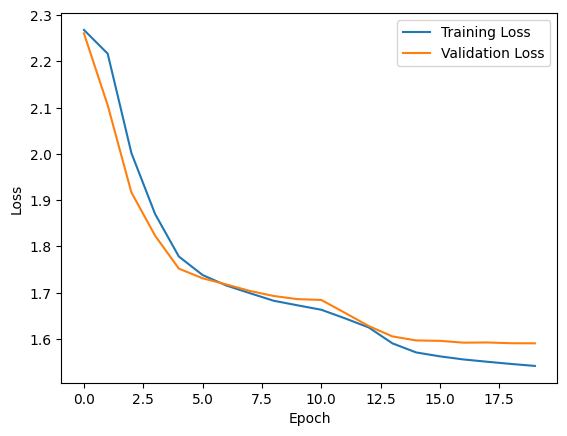

In [51]:
# plot the loss
plt.plot(list_loss, label="Training Loss")
plt.plot(list_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
# create a chatbot wich recieves a question and returns the tag
def predict_tag(question):
    # Preprocess the question
    processed_text = preprocess_text(question)

    # Tokenize the question
    encoded_text = [vocab.get(word, vocab['<UNK>']) for word in processed_text.split()]
    padded_text = encoded_text[:max_length] + [vocab['<PAD>']] * (max_length - len(encoded_text))
    x = torch.tensor(padded_text).unsqueeze(0)  # Add batch dimension
    x = x.to(device)

    # Get the model's prediction
    with torch.no_grad():
        output = model(x)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

In [54]:
# Test the chatbot
question = "linux command to list files in a directory"
tag = predict_tag(question)
print(f"Predicted tag: {top_100_tags[tag]}")

# get a answer for the question
answer = answers_and_questions_df[answers_and_questions_df["Tags_question"].apply(lambda tags: tags[0] == top_100_tags[tag])]["Body_answer"].iloc[0]
print(answer)

Predicted tag: linux
<p>have you tried watching the traffic between the GUI and the serial port to see if there is some kind of special command being sent across?  Also just curious, Python is sending ASCII and not UTF-8 or something else right?  The reason I ask is because I noticed your quote changes for the strings and in some languages that actually is the difference between ASCII and UTF-8.</p>



In [55]:
while True:
    question = input("Enter a question: ")
    tag = predict_tag(question)
    print(f"Predicted tag: {top_100_tags[tag]}")

    if question == "exit":
        break
    # shuffle the answers
    answers_and_questions_df = answers_and_questions_df
    answer = answers_and_questions_df[
    answers_and_questions_df["Tags_question"].apply(lambda tags: tags[0] == top_100_tags[tag])
]["Body_answer"].sample(n=1, random_state=random.randint(0, 1000)).iloc[0]
    print(answer)

Predicted tag: linux
<p>You're probably using an older version of Python.</p>

<p>The argparse module has been added pretty recently, in Python 2.7.</p>

Predicted tag: linux
<p>If you are looking at Python, then try this program. Its fairly simple to use, and the code can easily be customized <a href="http://aleph-null.tv/downloads/mpb-adduser-1.tgz" rel="nofollow">http://aleph-null.tv/downloads/mpb-adduser-1.tgz</a></p>

Predicted tag: string
<p>I don't know why I didn't think of this before, but there is another way to do this.</p>

<p>First, you read which rules should be used (or not used) into memory, I stored it into a dictionary.</p>

<pre><code>def readRulesIntoMemory(fileName):
    rules = {}

    # Open csv file with rule id, isUsed pairs
    fd = open(fileName, 'r')
    if fd:
        for line in fd.readlines():
            id,isUsed = line.split(',')
            rules[id] = isUsed
</code></pre>

<p>Then while reading the list of current rules in the other file, write your 

## 5.4 Hyperparameter Tuning
<!--
- Fine-tune the model using techniques like Grid Search or Random Search.
- Evaluate the impact of different hyperparameters.
-->

## 5.5 Model Testing
<!--
- Evaluate the final model on the test dataset.
- Ensure that the model generalizes well to unseen data.
-->

## 5.6 Model Interpretation (Optional)
<!--
- Interpret the model results (e.g., feature importance, SHAP values).
- Discuss the strengths and limitations of the model.
-->

---

# 6. Predictions


## 6.1 Make Predictions
<!--
- Use the trained model to make predictions on new/unseen data.
-->

## 6.2 Save Model and Results
<!--
- Save the trained model to disk for future use.
- Export prediction results for further analysis.
-->

---

# 7. Documentation and Reporting

## 7.1 Summary of Findings
<!--
- Summarize the results and findings of the analysis.
-->

## 7.2 Next Steps
<!--
- Suggest further improvements, alternative models, or future work.
-->

## 7.3 References
<!--
- Cite any resources, papers, or documentation used.
-->